## Gutenberg Preprocessing

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [81]:
import os
import pandas as pd
from tqdm import tqdm
import csv
import json
import numpy as np

In [3]:
folder = '/content/drive/MyDrive/cse475/GUTENBERG'

In [4]:
directories = [d for d in os.listdir(folder) if os.path.isdir(os.path.join(folder, d))]

num_directories = len(directories)

print(f"Number of authors: {num_directories}")

Number of authors: 12886


In [5]:
directories[0]

'J._Daley_McDonald'

In [8]:
authors_dirs = {}

In [17]:
for i in tqdm(range(0, len(directories))):
    directory = directories[i]
    path = os.path.join(folder, directory)
    files = os.listdir(path)
    if len(files) > 20:
      authors_dirs[directory] = len(files)

100%|██████████| 12886/12886 [00:13<00:00, 948.89it/s]


In [18]:
with open("/content/drive/MyDrive/cse475/authors_dirs.json", "w") as f:
  json.dump(authors_dirs, f)

In [19]:
sorted_authors = sorted(authors_dirs.items(), key=lambda item: item[1], reverse=True)
len(sorted_authors)

211

In [20]:
sorted_authors = [author for author in sorted_authors if author[0] != 'Anonymous']
len(sorted_authors)

210

In [22]:
sorted_authors = [author for author in sorted_authors if author[1] >= 20]
len(sorted_authors)

210

In [27]:
sorted_authors[1][1]

175

In [59]:
csv_file_path = 'files_and_authors.csv'

In [51]:
def strip_gutenberg_content_start(text):
  start_marker = "*** START OF THE PROJECT GUTENBERG"
  end_marker = "***"
  splits = text.split(start_marker)
  if len(splits) >= 2:
    content = splits[1].split(end_marker)[1]
    return content
  else:
    return text

def strip_gutenberg_content_end(text):
  start_marker = "*** END OF THE PROJECT GUTENBERG"
  splits = text.split(start_marker)
  if len(splits) >= 2:
    content = splits[0]
    return content
  else:
    return text

In [61]:
with open(csv_file_path, 'w', newline='') as csvfile:
  writer = csv.writer(csvfile)
  writer.writerow(['Author', 'Content'])

  pbar = tqdm(range(len(sorted_authors)), desc='All authors')
  # pbar = tqdm(range(1), desc='All authors')
  for i in pbar:
    author = sorted_authors[i][0]
    path = os.path.join(folder, author)
    files = os.listdir(path)

    for j in range(20):
      file = files[j]
      file_path = os.path.join(path, file)
      with open(file_path, 'r') as f:
        content = f.read().strip().replace('\n', '')
        content = strip_gutenberg_content_start(content)
        content = strip_gutenberg_content_end(content)
        writer.writerow([author, '"' + content + '"'])

All authors: 100%|██████████| 210/210 [01:47<00:00,  1.95it/s]


## Using our dataset

In [86]:
df = pd.read_csv(csv_file_path)
df

,Author,Content
0,Baron_Edward_Bulwer_Lytton_Lytton,"""Produced by Sue Asscher and David WidgerRIENZ..."
1,Baron_Edward_Bulwer_Lytton_Lytton,"""Produced by John T. Horner and David WidgerTH..."
2,Baron_Edward_Bulwer_Lytton_Lytton,"""Produced by Fred Ihde and David WidgerTHE COM..."
3,Baron_Edward_Bulwer_Lytton_Lytton,"""Produced by Dianne Bean, and David CeponisTHE..."
4,Baron_Edward_Bulwer_Lytton_Lytton,"""Produced by Dave Ceponis, Sue Asscher and Dav..."
...,...,...
4195,Annie_Besant,"""Produced by David Widger. *THE CHRISTI..."
4196,Annie_Besant,"""Produced by Jana Srna, Bryan Ness, Margo Romb..."
4197,Annie_Besant,"""Produced by David Widger from page images gen..."
4198,Annie_Besant,"""Produced by Larry B. Harrison, Bryan Ness and..."


In [87]:
df.describe()

,Author,Content
count,4200,4200
unique,210,4198
top,Baron_Edward_Bulwer_Lytton_Lytton,""""""
freq,20,3


In [88]:
df["Author"].unique()

array(['Baron_Edward_Bulwer_Lytton_Lytton', 'Georg_Ebers',
       'Alexandre_Dumas', 'Honoré_de_Balzac', 'Gilbert_Parker',
       'George_Manville_Fenn', 'Charles_Dickens', 'George_Meredith',
       'G._A._Henty', 'Arthur_Conan_Doyle', 'Émile_Zola', 'Andrew_Lang',
       'Jack_London', 'H._G._Wells', 'George_Sand', 'Henry_James',
       'graf_Leo_Tolstoy', 'Johann_Wolfgang_von_Goethe',
       'Anthony_Trollope', 'Edward_Stratemeyer', 'Guy_de_Maupassant',
       'Edward_Sylvester_Ellis', 'H._Rider_Haggard', 'Eugène_Sue',
       'George_MacDonald', 'Fergus_Hume', 'Charlotte_M._Yonge',
       'Bret_Harte', 'Carolyn_Wells', 'Anatole_France', 'Dante_Alighieri',
       'James_Grant', 'E._Phillips_Oppenheim', 'Daniel_Defoe',
       'John_Galsworthy', 'G._K._Chesterton', 'Henrik_Ibsen',
       'Friedrich_Schiller', 'Jacob_Abbott', 'George_O._Smith',
       'Benito_Pérez_Galdós', 'Charles_James_Lever',
       'August_Strindberg', 'Edgar_Rice_Burroughs', 'Bernard_Shaw',
       'Arnold_Benne

In [89]:
import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import PCA

## Term frequency vectorizer

In [90]:
ds_tfidf_vect = TfidfVectorizer(min_df=0.5, stop_words="english", max_features=450)
ds_freqs = ds_tfidf_vect.fit_transform(df['Content'])

In [91]:
len(ds_tfidf_vect.vocabulary_)

450

In [92]:
ds_freqs = ds_freqs.todense()

In [93]:
ds_freqs_df = pd.DataFrame(ds_freqs, index=df['Author'])
ds_freqs_df = ds_freqs_df.reset_index()
ds_freqs_df

,Author,0,1,2,3,4,5,6,7,8,...,440,441,442,443,444,445,446,447,448,449
0,Baron_Edward_Bulwer_Lytton_Lytton,0.012532,0.007240,0.012941,0.025282,0.003700,0.042591,0.009767,0.054400,0.041055,...,0.012228,0.034193,0.079681,0.031181,0.043325,0.011256,0.015782,0.045074,0.050341,0.098369
1,Baron_Edward_Bulwer_Lytton_Lytton,0.004060,0.006755,0.004192,0.013480,0.002589,0.031460,0.012205,0.078280,0.079805,...,0.015100,0.032978,0.054985,0.008334,0.054359,0.008205,0.013605,0.032000,0.061975,0.093798
2,Baron_Edward_Bulwer_Lytton_Lytton,0.005883,0.015295,0.006075,0.006104,0.006253,0.107971,0.023580,0.005970,0.057821,...,0.012156,0.052788,0.092582,0.043915,0.230206,0.011890,0.028992,0.080043,0.023633,0.131989
3,Baron_Edward_Bulwer_Lytton_Lytton,0.000000,0.000000,0.035760,0.005133,0.015775,0.005044,0.024786,0.135547,0.041676,...,0.025556,0.074760,0.028310,0.027696,0.032652,0.024996,0.000000,0.064987,0.109301,0.113350
4,Baron_Edward_Bulwer_Lytton_Lytton,0.003318,0.013802,0.019703,0.020657,0.004409,0.048211,0.005819,0.058928,0.060566,...,0.017141,0.022722,0.060131,0.044120,0.142357,0.009221,0.005723,0.035027,0.075812,0.090284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4195,Annie_Besant,0.008189,0.004258,0.012683,0.008496,0.021759,0.054267,0.028718,0.000000,0.026826,...,0.008460,0.015468,0.015619,0.022921,0.061766,0.004137,0.004035,0.126774,0.004112,0.031269
4196,Annie_Besant,0.065230,0.002339,0.018581,0.004667,0.000000,0.013759,0.009015,0.002282,0.014737,...,0.000000,0.036114,0.023597,0.107031,0.199347,0.002273,0.002217,0.016883,0.002259,0.006442
4197,Annie_Besant,0.008494,0.005888,0.040928,0.000000,0.000000,0.014432,0.002837,0.002873,0.000000,...,0.002925,0.010696,0.010800,0.021132,0.021355,0.017165,0.011161,0.031876,0.002843,0.002703
4198,Annie_Besant,0.013688,0.000000,0.017668,0.000000,0.010911,0.027911,0.000000,0.003472,0.009609,...,0.000000,0.019392,0.026109,0.051086,0.154869,0.134856,0.003373,0.000000,0.010309,0.013067


In [94]:
ds_freqs_df.to_csv('ds_freqs_df.csv')

In [95]:
pca = PCA(n_components=3)
vects_reduced = pca.fit_transform(np.asarray(ds_freqs))
vects_reduced.shape

(4200, 3)

In [96]:
pca_df = pd.DataFrame(
    vects_reduced,
    columns=['1st comp', '2nd comp', '3rd comp'],
    index=df["Author"]
)
pca_df

,1st comp,2nd comp,3rd comp
Author,,,
Baron_Edward_Bulwer_Lytton_Lytton,-0.188627,0.162214,-0.052393
Baron_Edward_Bulwer_Lytton_Lytton,-0.202486,0.065013,-0.048138
Baron_Edward_Bulwer_Lytton_Lytton,-0.129367,0.269771,-0.103126
Baron_Edward_Bulwer_Lytton_Lytton,0.046479,0.071893,-0.142150
Baron_Edward_Bulwer_Lytton_Lytton,-0.181334,0.193704,-0.050983
...,...,...,...
Annie_Besant,0.127094,0.318057,-0.086742
Annie_Besant,0.183289,0.377817,-0.089636
Annie_Besant,0.234907,0.180020,-0.026439


<ipython-input-106-df6bbf92f516>:19: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x_coord, y_coord, marker='o', c=author_colors[title], edgecolors='k')


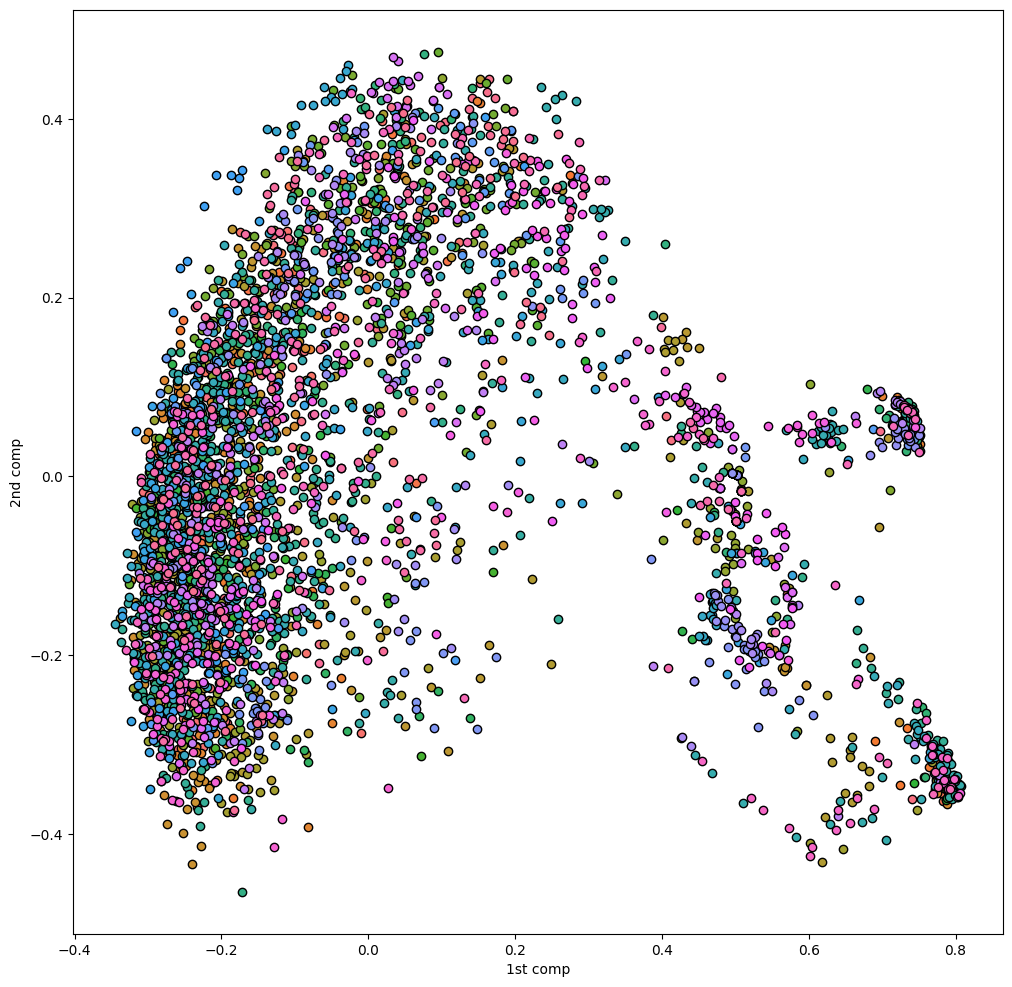

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns

colors = sns.color_palette("husl", len(df['Author'].unique()))
author_colors = dict(zip(df['Author'].unique(), colors))

ax = pca_df.plot(kind="scatter", x='1st comp', y='2nd comp', figsize=(12,12))

for title, points in pca_df.iterrows():
  x_coord = points['1st comp']
  y_coord = points['2nd comp']
  ax.scatter(x_coord, y_coord, marker='o', c=author_colors[title], edgecolors='k')

plt.show()


<ipython-input-133-2626899dd8b0>:16: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x_coord, y_coord, z_coord, marker='o', c=author_colors[title], edgecolors='k')


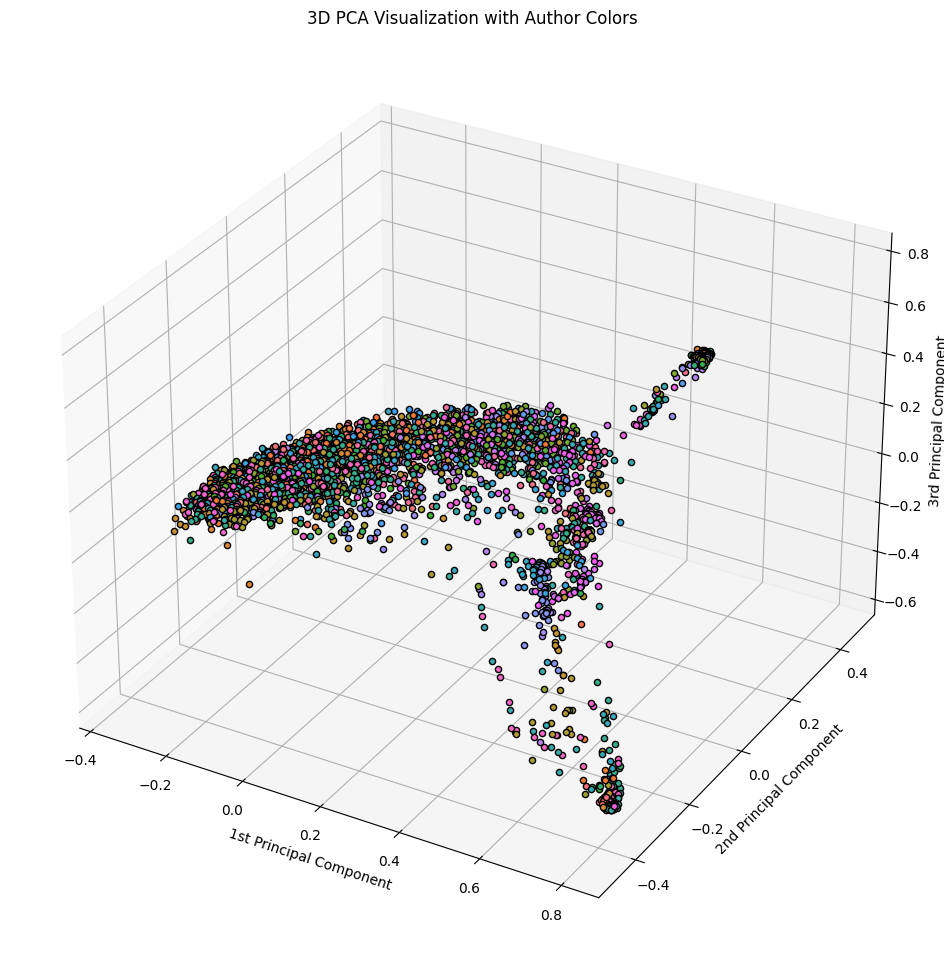

In [133]:
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

colors = sns.color_palette("husl", len(df['Author'].unique()))
author_colors = dict(zip(df['Author'].unique(), colors))

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

for title, points in pca_df.iterrows():
  x_coord = points['1st comp']
  y_coord = points['2nd comp']
  z_coord = points['3rd comp']
  ax.scatter(x_coord, y_coord, z_coord, marker='o', c=author_colors[title], edgecolors='k')

ax.set_xlabel("1st Principal Component")
ax.set_ylabel("2nd Principal Component")
ax.set_zlabel("3rd Principal Component")
ax.set_title("3D PCA Visualization with Author Colors")
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(ds_freqs_df.drop('Author', axis=1), ds_freqs_df['Author'], test_size=0.2, random_state=2024)

In [110]:
param_grid = {
  'penalty': ['l1', 'l2'],
  'C': [0.001, 0.01, 0.1, 1, 10],
  'solver': ['lbfgs', 'sag']
}

log_models_grid = GridSearchCV(LogisticRegression(), param_grid=param_grid, cv=5)

log_models_grid.fit(X_train, y_train)
print(f"Best Parameters: {log_models_grid.best_params_}")

best_log_model = log_models_grid.best_estimator_
y_pred = best_log_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
50 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.f

Best Parameters: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Test Accuracy: 0.7845


In [112]:
log_best_model_path = "/content/drive/MyDrive/cse475/log_best_model.pkl"

import pickle
with open(log_best_model_path, 'wb') as f:
  pickle.dump(best_log_model, f)

In [116]:
param_grid = {
  'n_estimators': [10, 50, 100],
  'max_depth': [4, 8, 12],
  'min_samples_split': [2, 5, 10],
  'min_samples_leaf': [1, 2, 4],
  'max_features': ['auto', 'sqrt', 'log2']
}

rand_models_grid = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv=2)

rand_models_grid.fit(X_train, y_train)
print(f"Best Parameters: {rand_models_grid.best_params_}")

best_rand_model = rand_models_grid.best_estimator_
y_pred = best_rand_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

Best Parameters: {'max_depth': 12, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Test Accuracy: 0.6083


In [121]:
rand_best_model_path = "/content/drive/MyDrive/cse475/rand_best_model.pkl"

import pickle
with open(rand_best_model_path, 'wb') as f:
  pickle.dump(best_rand_model, f)

In [119]:
param_grid = {
  'C': [0.01, 0.1, 1, 10, 100],
  'kernel': ['linear', 'rbf'],
  'gamma': ['auto', 0.01, 0.1, 1],
  'probability': [True]
}

svm_grid = GridSearchCV(SVC(), param_grid, cv=3)

svm_grid.fit(X_train, y_train)
print(f"Best Parameters: {svm_grid.best_params_}")

best_svm_model = svm_grid.best_estimator_
y_pred = best_svm_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

Best Parameters: {'C': 100, 'gamma': 'auto', 'kernel': 'linear'}
Test Accuracy: 0.8167


In [122]:
svm_best_model_path = "/content/drive/MyDrive/cse475/svm_best_model.pkl"

import pickle
with open(svm_best_model_path, 'wb') as f:
  pickle.dump(best_svm_model, f)

In [127]:
ensemble_model_hard = VotingClassifier(estimators=[
    ('lr', best_log_model), ('svm', best_svm_model), ('rf', best_rand_model)], voting='hard')

ensemble_model_hard.fit(X_train, y_train)

y_pred = ensemble_model_hard.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Ensembled Accuracy (hard): {accuracy:.4f}")

Ensembled Accuracy (hard): 0.7869


In [131]:
ensemble_model_soft = VotingClassifier(estimators=[
    ('lr', best_log_model), ('svm', best_svm_model), ('rf', best_rand_model)], voting='soft')

ensemble_model_soft.fit(X_train, y_train)

y_pred = ensemble_model_soft.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Ensembled Accuracy (soft): {accuracy:.4f}")

Ensembled Accuracy (soft): 0.7988
